In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, auc, classification_report, r2_score
from sklearn.model_selection import train_test_split, GroupShuffleSplit

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, InputLayer, LayerNormalization, Input, Attention, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Naming the columns
cols = ['engine_id', 'cycle', 'operational setting 1', 'operational setting 2', 'operational setting 3', 'sensor measurment 1', 'sensor measurment 2', 'sensor measurment 3', 'sensor measurment 4', 'sensor measurment 5', 'sensor measurment 6', 'sensor measurment 7', 'sensor measurment 8', 'sensor measurment 9', 'sensor measurment 10', 'sensor measurment 11', 'sensor measurment 12', 'sensor measurment 13', 'sensor measurment 14', 'sensor measurment 15','sensor measurment 16', 'sensor measurment 17', 'sensor measurment 18', 'sensor measurment 19', 'sensor measurment 20', 'sensor measurment 21', 'sensor measurment 22', 'sensor measurment 23', 'sensor measurment 24', 'sensor measurment 25', 'sensor measurment 26']

### Reading data

In [3]:
# Reading all the training Datasets (labels will be derived)
df_train1 = pd.read_csv(r"train_FD001.txt", sep=r"\s+", names=cols)
df_train2 = pd.read_csv(r"train_FD002.txt", sep=r"\s+", names=cols)
df_train3 = pd.read_csv(r"train_FD003.txt", sep=r"\s+", names=cols)
df_train4 = pd.read_csv(r"train_FD004.txt", sep=r"\s+", names=cols)

# Reading all the testing Datasets labels will be derived from RUL files
df_test1 = pd.read_csv(r"test_FD001.txt", sep=r"\s+", names=cols)
df_test2 = pd.read_csv(r"test_FD002.txt", sep=r"\s+", names=cols)
df_test3 = pd.read_csv(r"test_FD003.txt", sep=r"\s+", names=cols)
df_test4 = pd.read_csv(r"test_FD004.txt", sep=r"\s+", names=cols)

# Reading all the RUL files
rul1 = pd.read_csv(r"RUL_FD001.txt", sep=r"\s+", header=None, names=["RUL"])
rul2 = pd.read_csv(r"RUL_FD002.txt", sep=r"\s+", header=None, names=["RUL"])
rul3 = pd.read_csv(r"RUL_FD003.txt", sep=r"\s+", header=None, names=["RUL"])
rul4 = pd.read_csv(r"RUL_FD004.txt", sep=r"\s+", header=None, names=["RUL"])

In [4]:
print(f"Shape of test1: {df_test1.shape} , Shape of testlabels1: {rul1.shape}")
print(f"Shape of test2: {df_test2.shape} , Shape of testlabels2: {rul2.shape}")
print(f"Shape of test3: {df_test3.shape} , Shape of testlabels3: {rul3.shape}")
print(f"Shape of test4: {df_test4.shape} , Shape of testlabels4: {rul4.shape}")

Shape of test1: (13096, 31) , Shape of testlabels1: (100, 1)
Shape of test2: (33991, 31) , Shape of testlabels2: (259, 1)
Shape of test3: (16596, 31) , Shape of testlabels3: (100, 1)
Shape of test4: (41214, 31) , Shape of testlabels4: (248, 1)


In [5]:
print(df_train1['sensor measurment 22'].unique())
print(df_train1['sensor measurment 23'].unique())
print(df_train1['sensor measurment 24'].unique())
print(df_train1['sensor measurment 25'].unique())
print(df_train1['sensor measurment 26'].unique())

#As these columns are NAN, removing them cause they are impractical to use in NN

[nan]
[nan]
[nan]
[nan]
[nan]


In [6]:
#feature columns
feature_cols = [col for col in cols if col not in ['engine_id', 'cycle', 'RUL', 'sensor measurment 22', 'sensor measurment 23', 'sensor measurment 24', 'sensor measurment 25', 'sensor measurment 26']]

In [7]:
#Window Size
window_size = 30

In [8]:
drop_cols = ['sensor measurment 22', 'sensor measurment 23', 'sensor measurment 24',
             'sensor measurment 25', 'sensor measurment 26']

for df in [df_train1, df_train2, df_train3, df_train4, df_test1, df_test2, df_test3, df_test4]:
    df.drop(columns=drop_cols, inplace=True)

### Attaching RULs(labels) to Train dataset derived from Train dataset

In [9]:
def attach_train_rul(df):
    df.sort_values(['engine_id', 'cycle'], inplace=True)
    df['RUL'] = df.groupby('engine_id')['cycle'].transform(lambda x: x.max() - x)
    return df

In [10]:
#Adding RUL Values to the Train datasets only
df_train1 = attach_train_rul(df_train1)
df_train2 = attach_train_rul(df_train2)
df_train3 = attach_train_rul(df_train3)
df_train4 = attach_train_rul(df_train4)

### Attaching RULs to Test dataset from RUL files

In [11]:
rul1.head()

,RUL
0,112
1,98
2,69
3,82
4,91


In [12]:
#Attaching RUL to the test datasets from the RUL files based on engine_id
def attach_test_rul_from_file(test_df, rul):
    rul.columns = ["RUL"]
    rul["engine_id"] = rul.index + 1

    max_cycles = test_df.groupby("engine_id")["cycle"].max().reset_index()
    max_cycles.columns = ["engine_id", "MaxCycle"]

    rul = rul.merge(max_cycles, on="engine_id", how="left")

    test_df = test_df.merge(rul, on="engine_id", how="left")
    test_df["RUL"] = test_df["RUL"] + (test_df["MaxCycle"] - test_df["cycle"])

    return test_df.drop(columns=["MaxCycle"])

In [13]:
df_test1 = attach_test_rul_from_file(df_test1, rul1)
df_test2 = attach_test_rul_from_file(df_test2, rul2)
df_test3 = attach_test_rul_from_file(df_test3, rul3)
df_test4 = attach_test_rul_from_file(df_test4, rul4)

### Data preprocessing

Functions to preprocess data, will use for each subdataset seperately

In [14]:
def scale_dataset(train_df, test_df):
  train_df = train_df.copy()
  test_df = test_df.copy()

  sensor_cols = [col for col in train_df.columns if "sensor" in col]
  operational_settings = ['operational setting 1', 'operational setting 2', 'operational setting 3']

  # Using Standard scaler because some values in these columns are in negative
  std_scaler = StandardScaler()
  train_df[operational_settings] = std_scaler.fit_transform(train_df[operational_settings])
  test_df[operational_settings] = std_scaler.transform(test_df[operational_settings])

  # Using MinMax scaler for these because they don't have negative values
  minmax_scaler = MinMaxScaler()
  train_df[sensor_cols] = minmax_scaler.fit_transform(train_df[sensor_cols])
  test_df[sensor_cols] = minmax_scaler.transform(test_df[sensor_cols])

  # Clipping RUL values to reduce noise
  train_df['RUL'] = train_df['RUL'].clip(upper=125)
  test_df['RUL'] = test_df['RUL'].clip(upper=125)

  return train_df, test_df

In [15]:
#creating sliding windows to capture temporal patterns in sensor data so the model can learn how engine health evolves over time instead of looking at individual points
def create_sliding_windows_with_units(df, sequence_length, feature_cols):
    windows, labels, units = [], [], []
    df = df.sort_values(['engine_id', 'cycle'])

    for engine_id in df['engine_id'].unique():
        engine_data = df[df['engine_id'] == engine_id]
        feature_data = engine_data[feature_cols].values
        rul_data = engine_data['RUL'].values

        if len(feature_data) < sequence_length:
            continue

        #Creating sliding windows of sensor data with their corresponding RUL labels
        for start_idx in range(len(feature_data) - sequence_length + 1):
            end_idx = start_idx + sequence_length
            sequence = feature_data[start_idx:end_idx]
            target_rul = rul_data[end_idx - 1]

            windows.append(sequence)
            labels.append(target_rul)
            units.append(engine_id)

    return np.array(windows), np.array(labels), np.array(units)

In [16]:
#now we generate the last sequence of each engine for testing
def create_test_sequences(df, sequence_length, feature_cols):
    test_sequences = []
    engine_ids = []
    df = df.sort_values(['engine_id', 'cycle'])

    for engine_id in df['engine_id'].unique():
        engine_data = df[df['engine_id'] == engine_id]
        feature_data = engine_data[feature_cols].values

        if len(feature_data) < sequence_length:
            continue

        last_sequence = feature_data[-sequence_length:]
        test_sequences.append(last_sequence)
        engine_ids.append(engine_id)

    return np.array(test_sequences), np.array(engine_ids)

In [17]:
def get_test_rul(df_test, test_units, id_col="engine_id", rul_col="RUL"):
  #getting the test RUL values
  rul_values = []
  for engine_id in test_units:
      engine_rul = df_test[df_test[id_col] == engine_id][rul_col].iloc[-1]
      rul_values.append(engine_rul)
  return np.array(rul_values)

In [18]:
def split_train_val(X, y, groups, test_size=0.2, random_state=42):
    #Splitting into train/validation
    #using GroupShuffleSplit so each engine data stays in only one set and to avoid leakage

    gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    train_idx, val_idx = next(gss.split(X, y, groups=groups))
    X_train = X[train_idx]
    y_train = y[train_idx]
    X_val = X[val_idx]
    y_val = y[val_idx]
    return X_train, y_train, X_val, y_val

### Model Function

we will use this model structure for each subdataset with this function

In [19]:
def train_neural_network(X, y, X_val, y_val, window_size, epochs, learning_rate, model_name):
    model = Sequential()

    #LSTM layers with l2 regularization
    model.add(LSTM(256, return_sequences=True, input_shape=(window_size, X.shape[2]), kernel_regularizer=regularizers.l2(1e-7)))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    model.add(LSTM(128, return_sequences=True, kernel_regularizer=regularizers.l2(1e-7)))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    model.add(LSTM(64, return_sequences=False, kernel_regularizer=regularizers.l2(1e-7)))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    #dense layers
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='linear'))

    #callbacks
    early_stop = EarlyStopping(monitor='val_mse', patience=50, restore_best_weights=True, verbose=1, min_delta=1e-4)

    os.makedirs("models", exist_ok=True)
    model_path = os.path.join("models", model_name)
    check_point = ModelCheckpoint(model_path, save_best_only=True, save_weights_only=False, monitor='val_mse', mode='min', verbose=1)

    #custom learning rate scheduler
    def scheduler(epoch, lr):
        if epoch < 10:
            return lr
        elif epoch < 20:
            return lr * 0.9
        else:
            return lr * 0.95

    lr_scheduler = LearningRateScheduler(scheduler, verbose=1)

    #compiling
    optimizer = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-07, clipnorm=1.0)

    model.compile(loss=MeanSquaredError(), optimizer=optimizer, metrics=['mse', 'mae'])

    #fitting model with class weights and validation split
    history = model.fit(X, y, epochs=epochs, batch_size=32, callbacks=[check_point, early_stop, lr_scheduler], validation_data=(X_val, y_val), shuffle=True, verbose=1)

    return model, history

### Evaluation

In [20]:
def regression_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = int(np.sqrt(mse))
    r2 = r2_score(y_true, y_pred)

    return {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R2": r2
    }

### Plotting

shows how close the model predictions are vs the actual RUL values

In [21]:
def plot_true_vs_pred(model_name, X_test, y_test):
    model_path = os.path.join("models", model_name)
    model = load_model(model_path)
    y_pred = model.predict(X_test).flatten()

    plt.figure(figsize=(7,7))
    sns.scatterplot(x=y_test, y=y_pred, s=60, color="#3498db", edgecolor="k", alpha=0.7)
    max_val = max(y_test.max(), y_pred.max())
    plt.plot([0, max_val], [0, max_val], 'r--', lw=2)
    plt.xlabel("True RUL", fontsize=12, weight="bold")
    plt.ylabel("Predicted RUL", fontsize=12, weight="bold")
    plt.title(f"{model_name} - True vs Predicted RUL", fontsize=14, weight="bold")
    plt.grid(alpha=0.3)
    plt.show()

This graph displays the spread of prediction errors (how much the model over/under-predicts)

In [22]:
def plot_residuals(model_name, X_test, y_test):
    model_path = os.path.join("models", model_name)
    model = load_model(model_path)
    y_pred = model.predict(X_test).flatten()

    residuals = y_pred - y_test
    plt.figure(figsize=(7,5))
    sns.histplot(residuals, bins=40, color="#2ecc71", edgecolor="black", alpha=0.8, kde=True)
    plt.axvline(0, color='red', linestyle='--', linewidth=2)
    plt.xlabel("Prediction Error", fontsize=12, weight="bold")
    plt.ylabel("Count", fontsize=12, weight="bold")
    plt.title(f"{model_name} - Residuals Distribution", fontsize=14, weight="bold")
    plt.grid(alpha=0.3)
    plt.show()

Reveals how prediction errors vary depending on the actual RUL values

In [23]:
def plot_error_vs_true(model_name, X_test, y_test):
    model_path = os.path.join("models", model_name)
    model = load_model(model_path)
    y_pred = model.predict(X_test).flatten()

    errors = y_pred - y_test

    plt.figure(figsize=(10,6))
    sns.scatterplot(x=y_test, y=errors, color="#9b59b6", edgecolor="k", alpha=0.7)
    plt.axhline(0, color="red", linestyle="--", linewidth=2)
    plt.xlabel("True RUL", fontsize=12, weight="bold")
    plt.ylabel("Prediction Error", fontsize=12, weight="bold")
    plt.title(f"{model_name} - Error vs True RUL", fontsize=14, weight="bold")
    plt.grid(alpha=0.3)
    plt.show()

In [24]:
def RUL_vs_uniNumber_prediction(model_name, X_test, y_test):
  model_path = os.path.join("models", model_name)
  model = load_model(model_path)
  y_pred = model.predict(X_test).flatten()

  plt.figure(figsize=(10,5))
  plt.plot(y_pred, color='red', label='Prediction')
  plt.plot(y_test, color='blue', label='Ground Truth')
  plt.ylabel("RUL")
  plt.xlabel("Unit Number")
  plt.legend(loc='upper left')
  plt.show()

# Trainng, Evaluating models for each subdatasets

## For FD001

In [25]:
df_train1

,engine_id,cycle,operational setting 1,operational setting 2,operational setting 3,sensor measurment 1,sensor measurment 2,sensor measurment 3,sensor measurment 4,sensor measurment 5,...,sensor measurment 13,sensor measurment 14,sensor measurment 15,sensor measurment 16,sensor measurment 17,sensor measurment 18,sensor measurment 19,sensor measurment 20,sensor measurment 21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,4
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,3
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,2
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,1


In [26]:
df_test1

,engine_id,cycle,operational setting 1,operational setting 2,operational setting 3,sensor measurment 1,sensor measurment 2,sensor measurment 3,sensor measurment 4,sensor measurment 5,...,sensor measurment 13,sensor measurment 14,sensor measurment 15,sensor measurment 16,sensor measurment 17,sensor measurment 18,sensor measurment 19,sensor measurment 20,sensor measurment 21,RUL
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,142
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,141
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,140
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,139
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974,24
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771,23
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051,22
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699,21


In [27]:
df_train1.shape

(20631, 27)

In [28]:
df_test1.shape

(13096, 27)

In [29]:
train_df1, test_df1 = scale_dataset(df_train1, df_test1)

In [30]:
X_train1_all, y_train1_all, seq_units_1 = create_sliding_windows_with_units(train_df1, window_size, feature_cols)

In [31]:
X_test1, test_units_1 = create_test_sequences(test_df1, window_size, feature_cols)

In [32]:
y_test1 = get_test_rul(test_df1, test_units_1)

In [33]:
X_train1, y_train1, X_val1, y_val1 = split_train_val(X_train1_all, y_train1_all, seq_units_1)

In [34]:
model_1, history_1 = train_neural_network(X_train1, y_train1, X_val1, y_val1, window_size, 100, 0.001, "FD001_regressor_model.keras")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/100
446/446 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2800.8394 - mae: 38.2470 - mse: 2800.8394
Epoch 1: val_mse improved from inf to 459.82257, saving model to models/FD001_regressor_model.keras
446/446 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 2797.2180 - mae: 38.2144 - mse: 2797.2180 - val_loss: 459.8226 - val_mae: 18.7741 - val_mse: 459.8226 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/100
446/446 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 364.9355 - mae: 14.7913 - mse: 364.9355
Epoch 2: val_mse did not improve from 459.82257
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 364.9644 - mae: 14.7918 - mse: 364.9643 - val_loss: 1055.6780 - val_mae: 26.0009 - val_mse: 1055.6780 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/100
445/446 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

In [35]:
model_1 = load_model("models/FD001_regressor_model.keras")
y_prediction_1 = model_1.predict(X_test1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step


In [36]:
regression_metrics(y_test1, y_prediction_1)

{'MAE': 10.618844985961914,
 'MSE': 204.78494262695312,
 'RMSE': 14,
 'R2': 0.8724770545959473}

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step


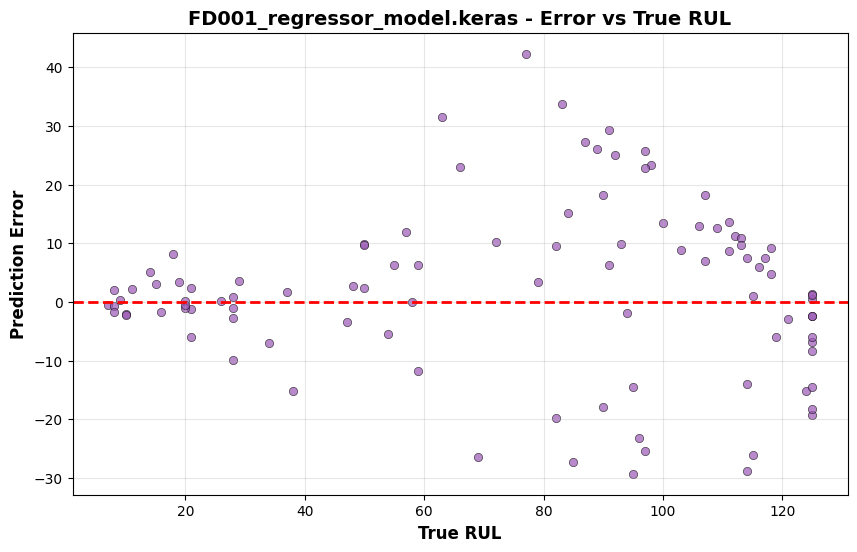

In [37]:
plot_error_vs_true("FD001_regressor_model.keras", X_test1, y_test1)

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step


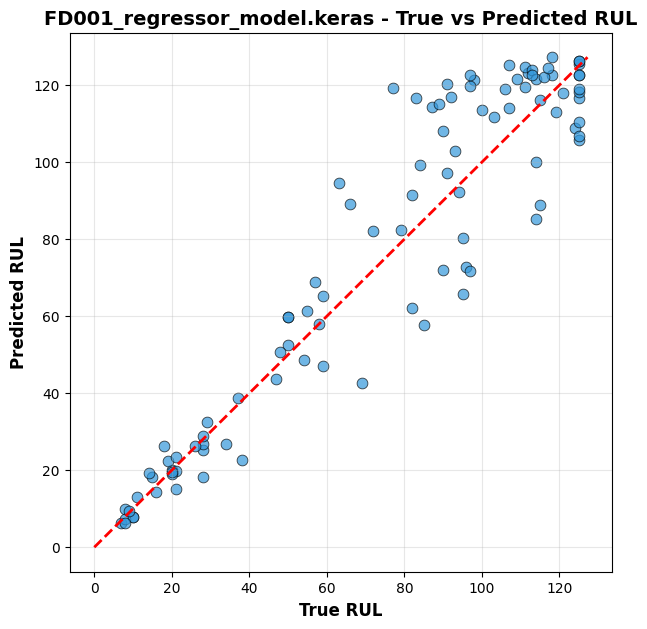

In [38]:
plot_true_vs_pred("FD001_regressor_model.keras", X_test1, y_test1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step


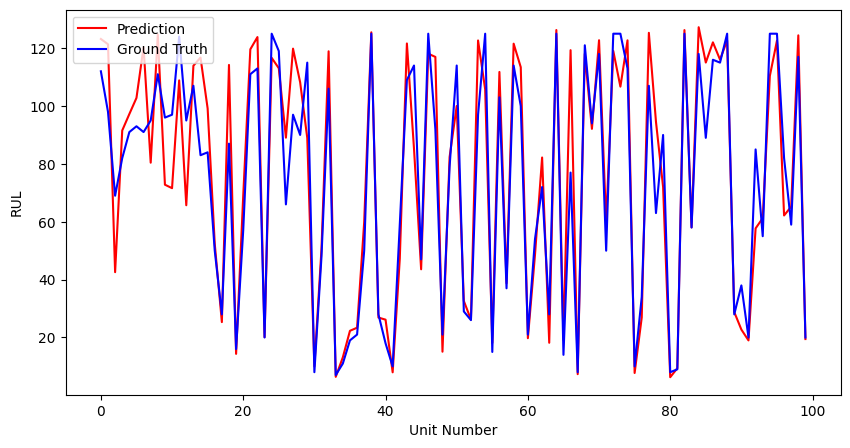

In [39]:
RUL_vs_uniNumber_prediction("FD001_regressor_model.keras", X_test1, y_test1)

## FD002

In [40]:
df_train2

,engine_id,cycle,operational setting 1,operational setting 2,operational setting 3,sensor measurment 1,sensor measurment 2,sensor measurment 3,sensor measurment 4,sensor measurment 5,...,sensor measurment 13,sensor measurment 14,sensor measurment 15,sensor measurment 16,sensor measurment 17,sensor measurment 18,sensor measurment 19,sensor measurment 20,sensor measurment 21,RUL
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071,148
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665,147
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723,146
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701,145
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286,144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53754,260,312,20.0037,0.7000,100.0,491.19,608.79,1495.60,1269.51,9.35,...,2389.02,8169.64,9.3035,0.03,369,2324,100.00,24.36,14.5189,4
53755,260,313,10.0022,0.2510,100.0,489.05,605.81,1514.32,1324.12,10.52,...,2388.42,8245.36,8.7586,0.03,374,2319,100.00,28.10,16.9454,3
53756,260,314,25.0041,0.6200,60.0,462.54,537.48,1276.24,1057.92,7.05,...,2030.33,7971.25,11.0657,0.02,310,1915,84.93,14.19,8.5503,2
53757,260,315,25.0033,0.6220,60.0,462.54,537.84,1272.95,1066.30,7.05,...,2030.35,7972.47,11.0537,0.02,311,1915,84.93,14.05,8.3729,1


In [41]:
df_test2

,engine_id,cycle,operational setting 1,operational setting 2,operational setting 3,sensor measurment 1,sensor measurment 2,sensor measurment 3,sensor measurment 4,sensor measurment 5,...,sensor measurment 13,sensor measurment 14,sensor measurment 15,sensor measurment 16,sensor measurment 17,sensor measurment 18,sensor measurment 19,sensor measurment 20,sensor measurment 21,RUL
0,1,1,9.9987,0.2502,100.0,489.05,605.03,1497.17,1304.99,10.52,...,2388.18,8114.10,8.6476,0.03,369,2319,100.00,28.42,17.1551,275
1,1,2,20.0026,0.7000,100.0,491.19,607.82,1481.20,1246.11,9.35,...,2388.12,8053.06,9.2405,0.02,364,2324,100.00,24.29,14.8039,274
2,1,3,35.0045,0.8400,100.0,449.44,556.00,1359.08,1128.36,5.48,...,2387.75,8053.04,9.3472,0.02,333,2223,100.00,14.98,8.9125,273
3,1,4,42.0066,0.8410,100.0,445.00,550.17,1349.69,1127.89,3.91,...,2387.72,8066.90,9.3961,0.02,332,2212,100.00,10.35,6.4181,272
4,1,5,24.9985,0.6213,60.0,462.54,536.72,1253.18,1050.69,7.05,...,2028.05,7865.66,10.8682,0.02,305,1915,84.93,14.31,8.5740,271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33986,259,119,35.0015,0.8403,100.0,449.44,555.56,1366.01,1129.47,5.48,...,2388.39,8088.36,9.3215,0.02,334,2223,100.00,14.94,8.9065,55
33987,259,120,42.0066,0.8405,100.0,445.00,549.42,1351.13,1123.86,3.91,...,2388.31,8108.48,9.3542,0.02,332,2212,100.00,10.57,6.4075,54
33988,259,121,42.0061,0.8400,100.0,445.00,549.65,1349.14,1118.91,3.91,...,2388.34,8098.77,9.3836,0.02,331,2212,100.00,10.57,6.4805,53
33989,259,122,0.0024,0.0003,100.0,518.67,642.58,1589.61,1408.16,14.62,...,2388.00,8161.85,8.4279,0.03,393,2388,100.00,39.08,23.3589,52


In [42]:
df_train2.shape

(53759, 27)

In [43]:
df_test2.shape

(33991, 27)

In [44]:
train_df2, test_df2 = scale_dataset(df_train2, df_test2)

In [45]:
X_train2_all, y_train2_all, seq_units_2 = create_sliding_windows_with_units(train_df2, window_size, feature_cols)

In [46]:
X_test2, test_units_2 = create_test_sequences(test_df2, window_size, feature_cols)

In [47]:
y_test2 = get_test_rul(test_df2, test_units_2)

In [48]:
X_train2, y_train2, X_val2, y_val2 = split_train_val(X_train2_all, y_train2_all, seq_units_2)

In [49]:
model_2, history_2 = train_neural_network(X_train2, y_train2, X_val2, y_val2, window_size, 100, 0.001, "FD002_regressor_model.keras")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/100
1169/1170 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2053.1921 - mae: 33.7687 - mse: 2053.1921
Epoch 1: val_mse improved from inf to 3141.93164, saving model to models/FD002_regressor_model.keras
1170/1170 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - loss: 2051.4727 - mae: 33.7524 - mse: 2051.4727 - val_loss: 3141.9316 - val_mae: 47.9553 - val_mse: 3141.9316 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/100
1167/1170 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 599.9172 - mae: 19.0956 - mse: 599.9172
Epoch 2: val_mse improved from 3141.93164 to 1612.06287, saving model to models/FD002_regressor_model.keras
1170/1170 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - loss: 599.7830 - mae: 19.0930 - mse: 599.7830 - val_loss: 1612.0630 - val_mae: 31.8251 - val_mse: 1612.0629 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.00

In [50]:
model_2 = load_model("models/FD002_regressor_model.keras")
y_prediction_2 = model_2.predict(X_test2)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


In [51]:
regression_metrics(y_test2, y_prediction_2)

{'MAE': 14.69748592376709,
 'MSE': 387.0867614746094,
 'RMSE': 19,
 'R2': 0.7883185148239136}

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


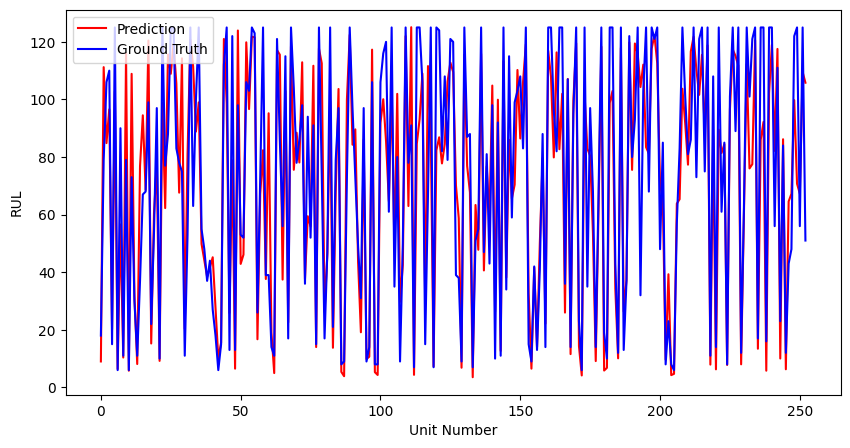

In [52]:
RUL_vs_uniNumber_prediction("FD002_regressor_model.keras", X_test2, y_test2)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


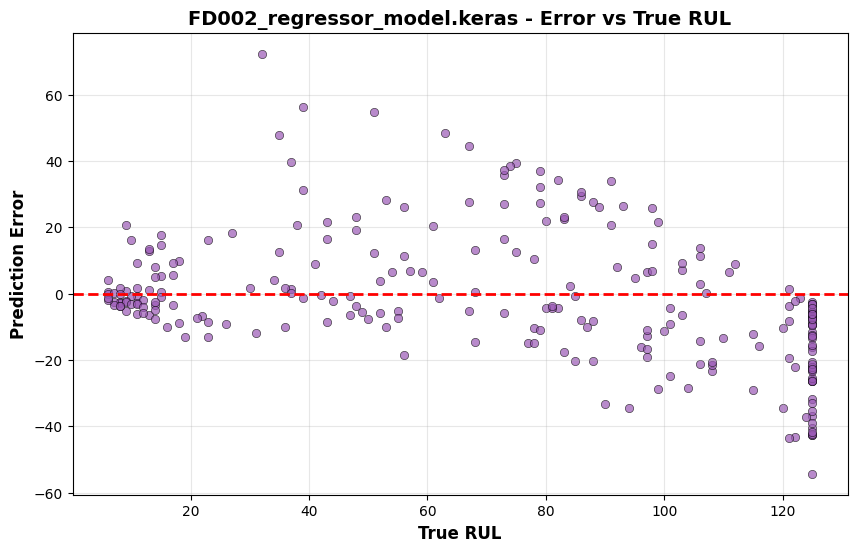

In [53]:
plot_error_vs_true("FD002_regressor_model.keras", X_test2, y_test2)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


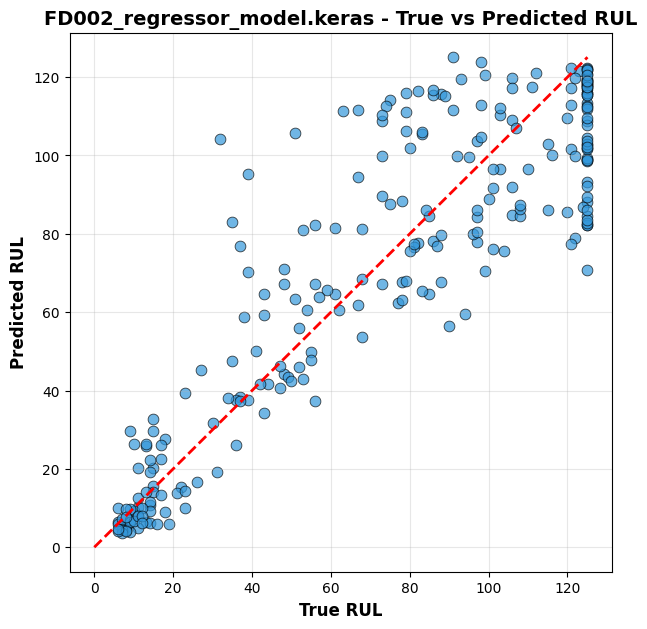

In [54]:
plot_true_vs_pred("FD002_regressor_model.keras", X_test2, y_test2)

## FD003

In [55]:
df_train3

,engine_id,cycle,operational setting 1,operational setting 2,operational setting 3,sensor measurment 1,sensor measurment 2,sensor measurment 3,sensor measurment 4,sensor measurment 5,...,sensor measurment 13,sensor measurment 14,sensor measurment 15,sensor measurment 16,sensor measurment 17,sensor measurment 18,sensor measurment 19,sensor measurment 20,sensor measurment 21,RUL
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537,258
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491,257
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669,256
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,...,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951,255
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,...,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583,254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24715,100,148,-0.0016,-0.0003,100.0,518.67,643.78,1596.01,1424.11,14.62,...,2388.30,8138.08,8.5036,0.03,394,2388,100.0,38.44,22.9631,4
24716,100,149,0.0034,-0.0003,100.0,518.67,643.29,1596.38,1429.14,14.62,...,2388.28,8144.36,8.5174,0.03,395,2388,100.0,38.50,22.9746,3
24717,100,150,-0.0016,0.0004,100.0,518.67,643.84,1604.53,1431.41,14.62,...,2388.24,8135.95,8.5223,0.03,396,2388,100.0,38.39,23.0682,2
24718,100,151,-0.0023,0.0004,100.0,518.67,643.94,1597.56,1426.57,14.62,...,2388.26,8141.24,8.5148,0.03,395,2388,100.0,38.31,23.0753,1


In [56]:
df_test3

,engine_id,cycle,operational setting 1,operational setting 2,operational setting 3,sensor measurment 1,sensor measurment 2,sensor measurment 3,sensor measurment 4,sensor measurment 5,...,sensor measurment 13,sensor measurment 14,sensor measurment 15,sensor measurment 16,sensor measurment 17,sensor measurment 18,sensor measurment 19,sensor measurment 20,sensor measurment 21,RUL
0,1,1,-0.0017,-0.0004,100.0,518.67,641.94,1581.93,1396.93,14.62,...,2387.94,8133.48,8.3760,0.03,391,2388,100.0,39.07,23.4468,276
1,1,2,0.0006,-0.0002,100.0,518.67,642.02,1584.86,1398.90,14.62,...,2388.01,8137.44,8.4062,0.03,391,2388,100.0,39.04,23.4807,275
2,1,3,0.0014,-0.0003,100.0,518.67,641.68,1581.78,1391.92,14.62,...,2387.94,8138.25,8.3553,0.03,391,2388,100.0,39.10,23.4244,274
3,1,4,0.0027,0.0001,100.0,518.67,642.20,1584.53,1395.34,14.62,...,2387.96,8137.07,8.3709,0.03,392,2388,100.0,38.97,23.4782,273
4,1,5,-0.0001,0.0001,100.0,518.67,642.46,1589.03,1395.86,14.62,...,2387.97,8134.20,8.4146,0.03,391,2388,100.0,39.09,23.3950,272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16591,100,243,0.0011,-0.0003,100.0,518.67,643.04,1594.99,1411.28,14.62,...,2388.24,8162.24,8.2939,0.03,395,2388,100.0,39.40,23.4949,32
16592,100,244,-0.0024,0.0002,100.0,518.67,642.47,1591.27,1417.64,14.62,...,2388.26,8163.24,8.3247,0.03,394,2388,100.0,39.42,23.6011,31
16593,100,245,-0.0053,0.0002,100.0,518.67,642.70,1593.81,1412.70,14.62,...,2388.28,8162.12,8.3264,0.03,394,2388,100.0,39.43,23.5482,30
16594,100,246,-0.0006,0.0001,100.0,518.67,642.19,1595.63,1406.58,14.62,...,2388.33,8164.20,8.2908,0.03,395,2388,100.0,39.40,23.6687,29


In [57]:
df_train3.shape

(24720, 27)

In [58]:
df_test3.shape

(16596, 27)

In [59]:
train_df3, test_df3 = scale_dataset(df_train3, df_test3)

In [60]:
X_train3_all, y_train3_all, seq_units_3 = create_sliding_windows_with_units(train_df3, window_size, feature_cols)

In [61]:
X_test3, test_units_3 = create_test_sequences(test_df3, window_size, feature_cols)

In [62]:
y_test3 = get_test_rul(test_df3, test_units_3)

In [63]:
X_train3, y_train3, X_val3, y_val3 = split_train_val(X_train3_all, y_train3_all, seq_units_3)

In [64]:
model_3, history_3 = train_neural_network(X_train3, y_train3, X_val3, y_val3, window_size, 100, 0.001, "FD003_regressor_model.keras")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/100
553/553 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2874.3835 - mae: 38.4860 - mse: 2874.3835
Epoch 1: val_mse improved from inf to 424.64572, saving model to models/FD003_regressor_model.keras
553/553 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 2871.3262 - mae: 38.4589 - mse: 2871.3262 - val_loss: 424.6458 - val_mae: 17.2517 - val_mse: 424.6457 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/100
551/553 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 381.9948 - mae: 14.8404 - mse: 381.9948
Epoch 2: val_mse improved from 424.64572 to 332.04614, saving model to models/FD003_regressor_model.keras
553/553 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 381.9368 - mae: 14.8391 - mse: 381.9367 - val_loss: 332.0462 - val_mae: 12.1021 - val_mse: 332.0461 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001000000047497451

In [65]:
model_3 = load_model("models/FD003_regressor_model.keras")
y_prediction_3 = model_3.predict(X_test3)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step


In [66]:
regression_metrics(y_test3, y_prediction_3)

{'MAE': 11.295984268188477,
 'MSE': 274.7621154785156,
 'RMSE': 16,
 'R2': 0.8208831548690796}

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step


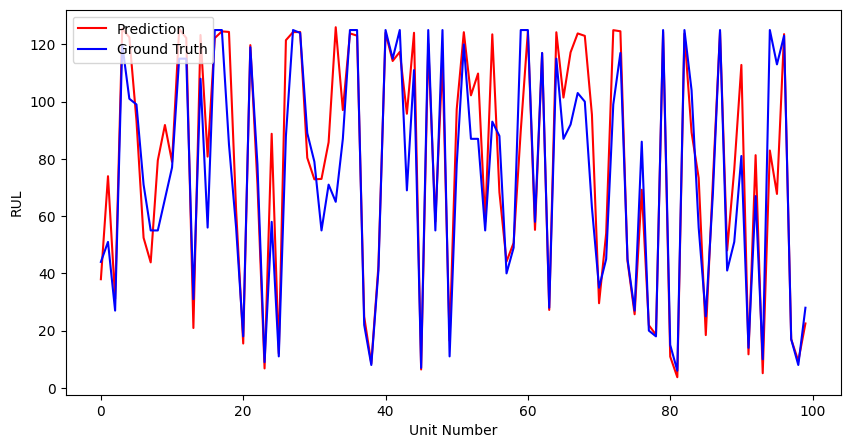

In [67]:
RUL_vs_uniNumber_prediction("FD003_regressor_model.keras", X_test3, y_test3)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step


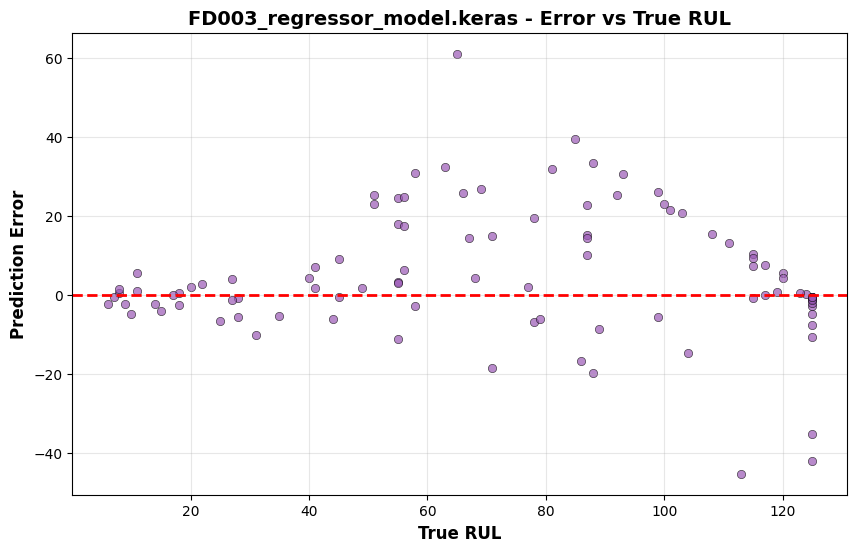

In [68]:
plot_error_vs_true("FD003_regressor_model.keras", X_test3, y_test3)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step


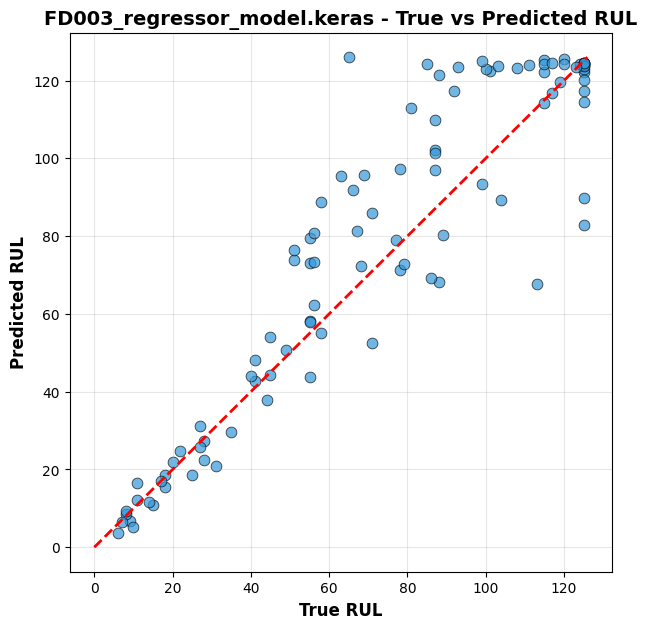

In [69]:
plot_true_vs_pred("FD003_regressor_model.keras", X_test3, y_test3)

## FD004

In [70]:
df_train4

,engine_id,cycle,operational setting 1,operational setting 2,operational setting 3,sensor measurment 1,sensor measurment 2,sensor measurment 3,sensor measurment 4,sensor measurment 5,...,sensor measurment 13,sensor measurment 14,sensor measurment 15,sensor measurment 16,sensor measurment 17,sensor measurment 18,sensor measurment 19,sensor measurment 20,sensor measurment 21,RUL
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,2387.99,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670,320
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,2387.73,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552,319
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,2387.97,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213,318
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,2388.02,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176,317
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,2028.08,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754,316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61244,249,251,9.9998,0.2500,100.0,489.05,605.33,1516.36,1315.28,10.52,...,2388.73,8185.69,8.4541,0.03,372,2319,100.00,29.11,17.5234,4
61245,249,252,0.0028,0.0015,100.0,518.67,643.42,1598.92,1426.77,14.62,...,2388.46,8185.47,8.2221,0.03,396,2388,100.00,39.38,23.7151,3
61246,249,253,0.0029,0.0000,100.0,518.67,643.68,1607.72,1430.56,14.62,...,2388.48,8193.94,8.2525,0.03,395,2388,100.00,39.78,23.8270,2
61247,249,254,35.0046,0.8400,100.0,449.44,555.77,1381.29,1148.18,5.48,...,2388.83,8125.64,9.0515,0.02,337,2223,100.00,15.26,9.0774,1


In [71]:
df_test4

,engine_id,cycle,operational setting 1,operational setting 2,operational setting 3,sensor measurment 1,sensor measurment 2,sensor measurment 3,sensor measurment 4,sensor measurment 5,...,sensor measurment 13,sensor measurment 14,sensor measurment 15,sensor measurment 16,sensor measurment 17,sensor measurment 18,sensor measurment 19,sensor measurment 20,sensor measurment 21,RUL
0,1,1,20.0072,0.7000,100.0,491.19,606.67,1481.04,1227.81,9.35,...,2387.78,8048.98,9.2229,0.02,362,2324,100.00,24.31,14.7007,251
1,1,2,24.9984,0.6200,60.0,462.54,536.22,1256.17,1031.48,7.05,...,2028.09,7863.46,10.8632,0.02,306,1915,84.93,14.36,8.5748,250
2,1,3,42.0000,0.8420,100.0,445.00,549.23,1340.13,1105.88,3.91,...,2387.95,8071.13,9.3960,0.02,328,2212,100.00,10.39,6.4365,249
3,1,4,42.0035,0.8402,100.0,445.00,549.19,1339.70,1107.26,3.91,...,2387.90,8078.89,9.3594,0.02,328,2212,100.00,10.56,6.2367,248
4,1,5,35.0079,0.8400,100.0,449.44,555.10,1353.04,1117.80,5.48,...,2387.87,8057.83,9.3030,0.02,333,2223,100.00,14.85,8.9326,247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41209,248,277,41.9991,0.8401,100.0,445.00,550.30,1364.40,1129.17,3.91,...,2388.50,8112.61,9.4427,0.02,331,2212,100.00,10.53,6.2620,30
41210,248,278,20.0026,0.7005,100.0,491.19,608.00,1494.75,1260.88,9.35,...,2388.33,8086.83,9.2772,0.02,366,2324,100.00,24.33,14.6486,29
41211,248,279,34.9988,0.8413,100.0,449.44,555.92,1370.65,1130.97,5.48,...,2388.64,8100.84,9.3982,0.02,336,2223,100.00,14.69,8.8389,28
41212,248,280,20.0027,0.7000,100.0,491.19,608.19,1489.11,1256.25,9.35,...,2388.37,8085.24,9.2727,0.03,366,2324,100.00,24.44,14.6887,27


In [72]:
df_train4.shape

(61249, 27)

In [73]:
df_test4.shape

(41214, 27)

In [74]:
train_df4, test_df4 = scale_dataset(df_train4, df_test4)

In [75]:
X_train4_all, y_train4_all, seq_units_4 = create_sliding_windows_with_units(train_df4, window_size, feature_cols)

In [76]:
X_test4, test_units_4 = create_test_sequences(test_df4, window_size, feature_cols)

In [77]:
y_test4 = get_test_rul(test_df4, test_units_4)

In [78]:
X_train4, y_train4, X_val4, y_val4 = split_train_val(X_train4_all, y_train4_all, seq_units_4)

In [79]:
model_4, history_4 = train_neural_network(X_train4, y_train4, X_val4, y_val4, window_size, 100, 0.001, "FD004_regressor_model.keras")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/100
1361/1361 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1847.1404 - mae: 30.8544 - mse: 1847.1404
Epoch 1: val_mse improved from inf to 588.06995, saving model to models/FD004_regressor_model.keras
1361/1361 ━━━━━━━━━━━━━━━━━━━━ 26s 16ms/step - loss: 1846.4517 - mae: 30.8478 - mse: 1846.4517 - val_loss: 588.0699 - val_mae: 17.9655 - val_mse: 588.0699 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/100
1360/1361 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 531.4426 - mae: 17.3223 - mse: 531.4426
Epoch 2: val_mse did not improve from 588.06995
1361/1361 ━━━━━━━━━━━━━━━━━━━━ 42s 17ms/step - loss: 531.4102 - mae: 17.3216 - mse: 531.4102 - val_loss: 1175.2493 - val_mae: 26.3383 - val_mse: 1175.2493 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/100
1358/1361 ━━━━━━━━━━━━━━━━━━━━ 0

In [80]:
model_4 = load_model("models/FD004_regressor_model.keras")
y_prediction_4 = model_4.predict(X_test4)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


In [81]:
regression_metrics(y_test4, y_prediction_4)

{'MAE': 16.70838737487793,
 'MSE': 539.8678588867188,
 'RMSE': 23,
 'R2': 0.7045993804931641}

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


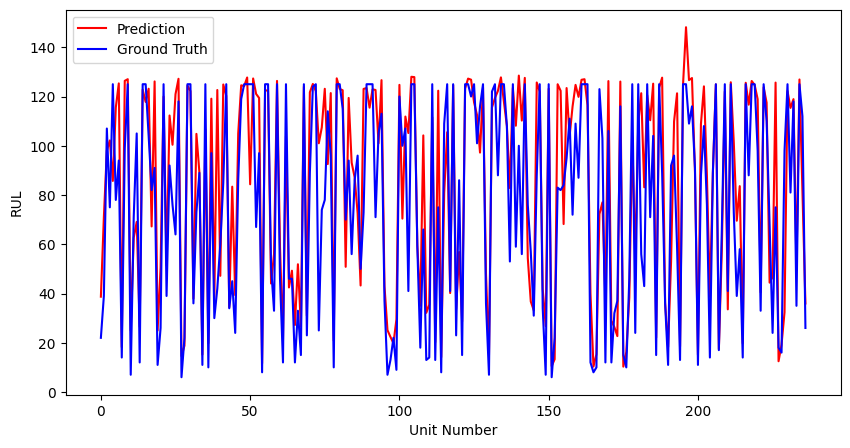

In [82]:
RUL_vs_uniNumber_prediction("FD004_regressor_model.keras", X_test4, y_test4)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


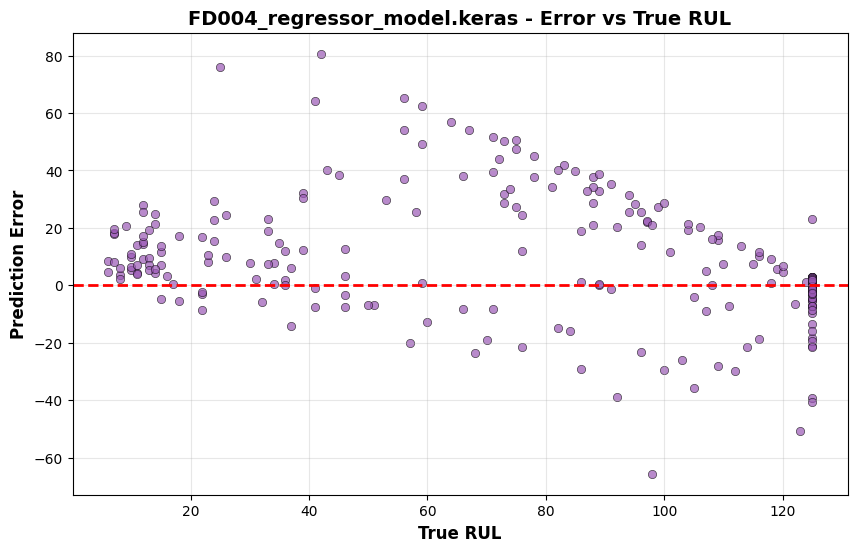

In [83]:
plot_error_vs_true("FD004_regressor_model.keras", X_test4, y_test4)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


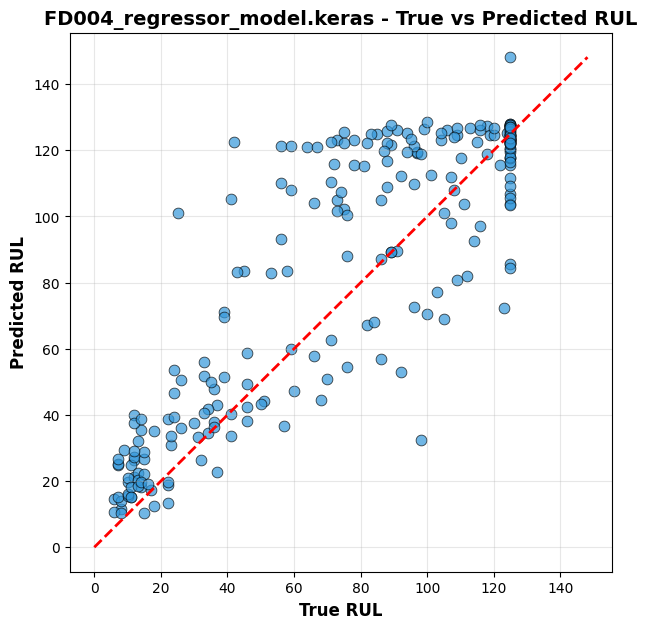

In [84]:
plot_true_vs_pred("FD004_regressor_model.keras", X_test4, y_test4)